In [10]:
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../")

from calib.rs_utils import RealSense

In [11]:
from IPython.display import display, Image

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [13]:
# nishikadoma
crop_settings = [{"crop_size_x": 240, "crop_size_y": 240, "crop_center_x": 320, "crop_center_y": 240}]
# D405  tsu
# crop_settings = [{"crop_size": 260, "crop_center_x": 350, "crop_center_y": 240}]

cam = RealSense(crop_settings=crop_settings)
camera_id = 0

ratio = np.load("../calib/camera_info/ratio.npy")
# center_pixels = [cam.crop_settings[camera_id]["crop_center_x"], cam.crop_settings[camera_id]["crop_center_y"]]
diff_center = crop_settings[camera_id]["crop_center_x"] - 320 
# center_pixels = [crop_settings[camera_id]["crop_size"]//2, crop_settings[camera_id]["crop_size"]//2]
center_pixels = [crop_settings[camera_id]["crop_size_x"]//2 - diff_center, (crop_settings[camera_id]["crop_size_y"])//2]
print(center_pixels)

color_intrinsics: [ 640x480  p[320.517 235.495]  f[432.669 432.309]  Inverse Brown Conrady [-0.0546599 0.0565423 0.000742147 0.00048023 -0.0185204] ]
['Intel RealSense D405'] ['123622270068']
[120, 120]


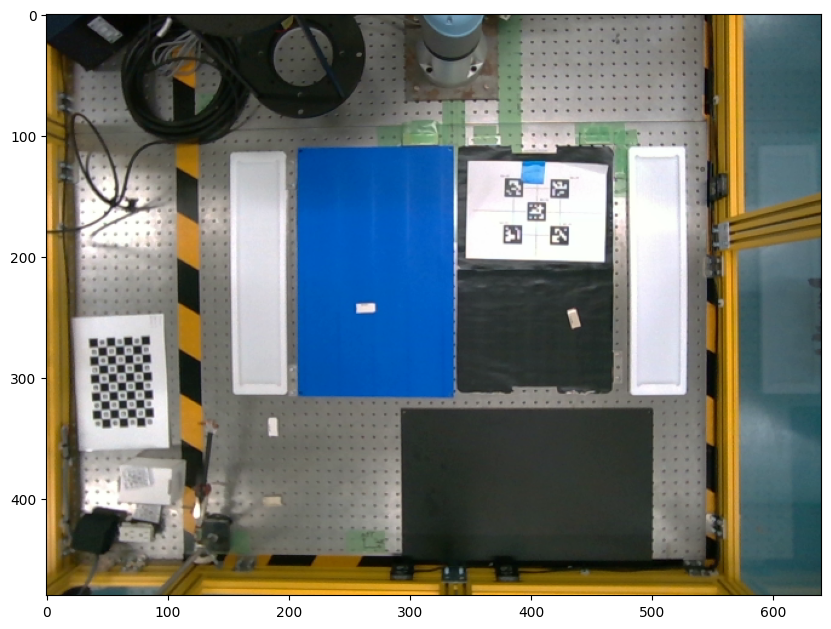

In [14]:
images, depth_images, mask_images, max_contours = cam.get_image()
image = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()  

In [15]:
ref_folder_path = "ref_pd"

output_path = 'outputs2'
file_name = "original"
ext = "png"

In [7]:

ref_save_folder_path = ref_folder_path
os.makedirs(ref_save_folder_path, exist_ok=True)


In [16]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import cv2

p = []

cv2.imwrite(os.path.join(ref_save_folder_path, f"{file_name}.{ext}"), image)

img_trace = px.imshow(image)
img_fig = go.FigureWidget()
img_fig.add_trace(img_trace.data[0])

def on_click_figure(trace, points, state):
    x, y = points.point_inds[0]
    p.append([y,x])
    img_fig.add_trace(go.Scatter(x=[y], y=[x], mode='markers'))
    scatter = img_fig.data[-1]

img_fig.data[0].on_click(on_click_figure)


display(img_fig)

FigureWidget({
    'data': [{'hovertemplate': 'x: %{x}<br>y: %{y}<br>color: [%{z[0]}, %{z[1]}, %{z[2]}]<extra></extra>',
              'name': '0',
              'source': ('data:image/png;base64,iVBORw0K' ... 'T/AVmwkGzf1+L2AAAAAElFTkSuQmCC'),
              'type': 'image',
              'uid': '4e4312da-5474-4877-b943-2655d89142e8',
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'template': '...'}
})

In [ ]:
print(p)

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../sam/sam_vit_h.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [ ]:
input_point = np.array([p[-1]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [ ]:
best_idx = np.argmax(scores)
final_mask = masks[best_idx]
masked_image = np.zeros((final_mask.shape[0], final_mask.shape[1], 3), dtype=np.uint8)
masked_image[final_mask, :] = image[final_mask, :]
cv2.imwrite(os.path.join(ref_folder_path, f"masked_image.{ext}"), cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR))

mask_colors = np.zeros((final_mask.shape[0], final_mask.shape[1], 3), dtype=np.uint8)
mask_colors[final_mask, :] = np.array([[0, 0, 128]])
cv2.imwrite(os.path.join(ref_folder_path, f"mask.{ext}"), mask_colors)